### 1. Load Environment Variables

First, we load the necessary environment variables from the `.env` file, such as API keys and the model engine to be used.

### 2. Set Experiment Parameters

Configure the parameters for the `run.py` script. These are the same variables found at the top of `wsd.sh`.

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# You can check the loaded variables here
print(f"Using Model: {os.getenv('MODEL_ENGINE')}")

Using Model: gemini-2.5-pro


### 3. Run Anomaly Detection

This cell executes the main `run.py` script with the parameters defined above. The output, including progress and any errors, will be displayed in real-time.

In [2]:
TRANS_BETA = 0
TRANS_ALPHA = 99
TEST_RATIO = 0.05
WINDOW_SIZE = 400
RETRIEVE_POSITIVE_NUM = 2
RETRIEVE_NEGATIVE_NUM = 1
RETRIEVE_DATABASE_RATIO = 0.1
DELETE_ZERO = 1
PROMPT_MODE = 1 # For WSD dataset
DATA_ROOT_DIR = "data"
SAVE_DIR = "result"

In [3]:
import datetime

# Get model name for suffix from environment variables
model_engine_name = os.getenv("MODEL_ENGINE", "unknown_model")
# Extract the main part of the model name for the suffix (e.g., 'gpt' or 'gemini')
model_suffix = model_engine_name.split('-')[0]
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

# Construct the run name for organization, now including the model suffix and timestamp
RUN_NAME = f"WSD_interactive_prompt_{PROMPT_MODE}_win_{WINDOW_SIZE}_beta{TRANS_BETA}alpha{TRANS_ALPHA}_p{RETRIEVE_POSITIVE_NUM}n{RETRIEVE_NEGATIVE_NUM}_{model_suffix}_{timestamp}"

# --- End of Parameters ---

# Create the target directory for results
result_path = os.path.join(SAVE_DIR, RUN_NAME)
os.makedirs(result_path, exist_ok=True)

print(f"Results will be saved in: {result_path}")

Results will be saved in: result/WSD_interactive_prompt_1_win_400_beta0alpha99_p2n1_gemini_202511171541


### 4. Evaluate the Results

After the detection process is complete, run the evaluation script to calculate performance metrics.

In [4]:
# The `wsd.sh` script runs the command twice in a loop. 
# Here, we run it once for simplicity. You can run this cell again if needed.

!python src/main.py \
    --trans_beta {TRANS_BETA} \
    --trans_alpha {TRANS_ALPHA} \
    --test_ratio {TEST_RATIO} \
    --window_size {WINDOW_SIZE} \
    --retrieve_positive_num {RETRIEVE_POSITIVE_NUM} \
    --retrieve_database_ratio {RETRIEVE_DATABASE_RATIO} \
    --prompt_mode {PROMPT_MODE} \
    --run_name {RUN_NAME} \
    --infer_data_path "{DATA_ROOT_DIR}/WSD" \
    --retreive_data_path "{DATA_ROOT_DIR}/WSD" \
    --sub_company 'all' \
    --delete_zero {DELETE_ZERO} \
    --result_save_dir "{SAVE_DIR}" \
    --no_affine_transform
    # To enable affine transform, comment out or remove the line above

Building retrieval database: 100%|████████████████| 3/3 [00:00<00:00,  5.56it/s]
Total anomaly examples in database: 1
Found 3 files to process.

[1/3] Processing file: 168
Affine transformation is disabled. Applying simple min-max scaling.
 -> Data loaded and preprocessed.
 -> Preparing retrieval data (normal/anomaly examples)...
 -> Found 19 normal examples and 1 anomaly examples.
   -> Processing window 1 / 1...
      -> Calling LLM for anomaly detection...
      -> LLM response received. Saving results...
   -> Processing window 2 / 1...
      -> Calling LLM for anomaly detection...
      -> LLM response received. Saving results...
   -> Processing window 3 / 1...
      -> Calling LLM for anomaly detection...
      -> LLM response received. Saving results...
   -> Processing window 4 / 1...
      -> Calling LLM for anomaly detection...
      -> LLM response received. Saving results...
   -> Processing window 5 / 1...
      -> Calling LLM for anomaly detection...
      -> LLM respon

### 5. Review the Results

You can now use the visualization notebook to see the results of this run. 

1. Open the `visualize_results.ipynb` notebook.
2. Set the `RESULT_DIR` variable in that notebook to the path printed above (the value of `result_path`).
3. Run the cells in the visualization notebook.

In [11]:
!python3 Eval/Metric_multi.py \
    --path {result_path}

raw score
adjust F1 Score: 0.5535055350553506
Precision: 0.40106951871657753
Recall: 0.8928571428571429
delay F1 Score: 0.5535055350553506
delay Precision: 0.40106951871657753
delay Recall: 0.8928571428571429
100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 13.18it/s]
best num_threshold: 9
best F1
adjust F1 Score: 0.8982035928143712
Precision: 0.9036144578313253
Recall: 0.8928571428571429
delay F1 Score: 0.8982035928143712
delay Precision: 0.9036144578313253
delay Recall: 0.8928571428571429


### 6. Visualize the Results Directly

This section provides the code to visualize the results directly within this notebook, so you don't have to switch to `visualize_results.ipynb`. The code below will find the `predict.csv` files in the `result_path` defined in Cell 5 and plot them.

Searching for result files in: result/WSD_interactive_prompt_1_win_400_beta0alpha99_p2n1_gemini_202511171541
Found 3 result file(s) to visualize.


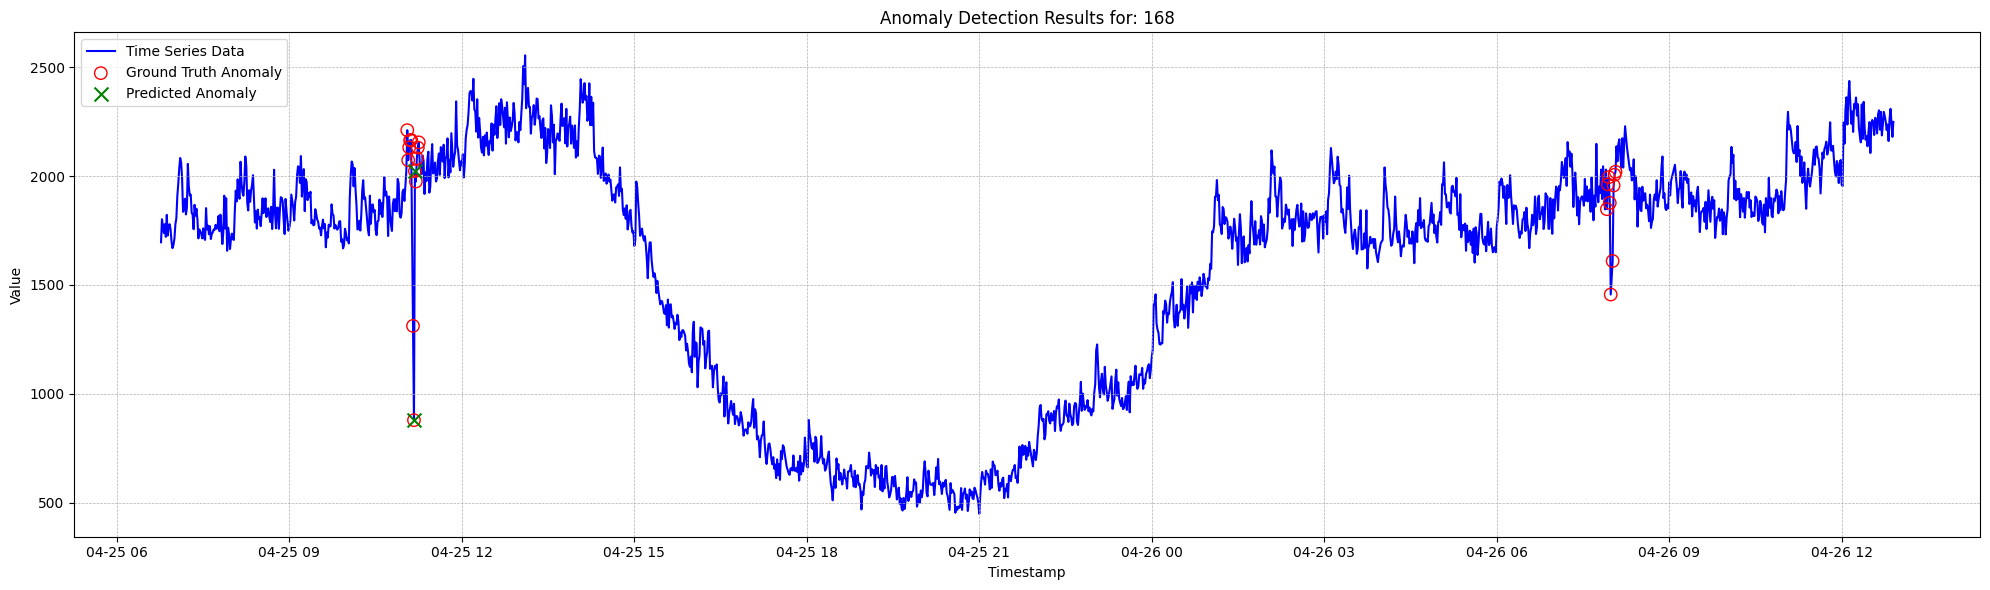

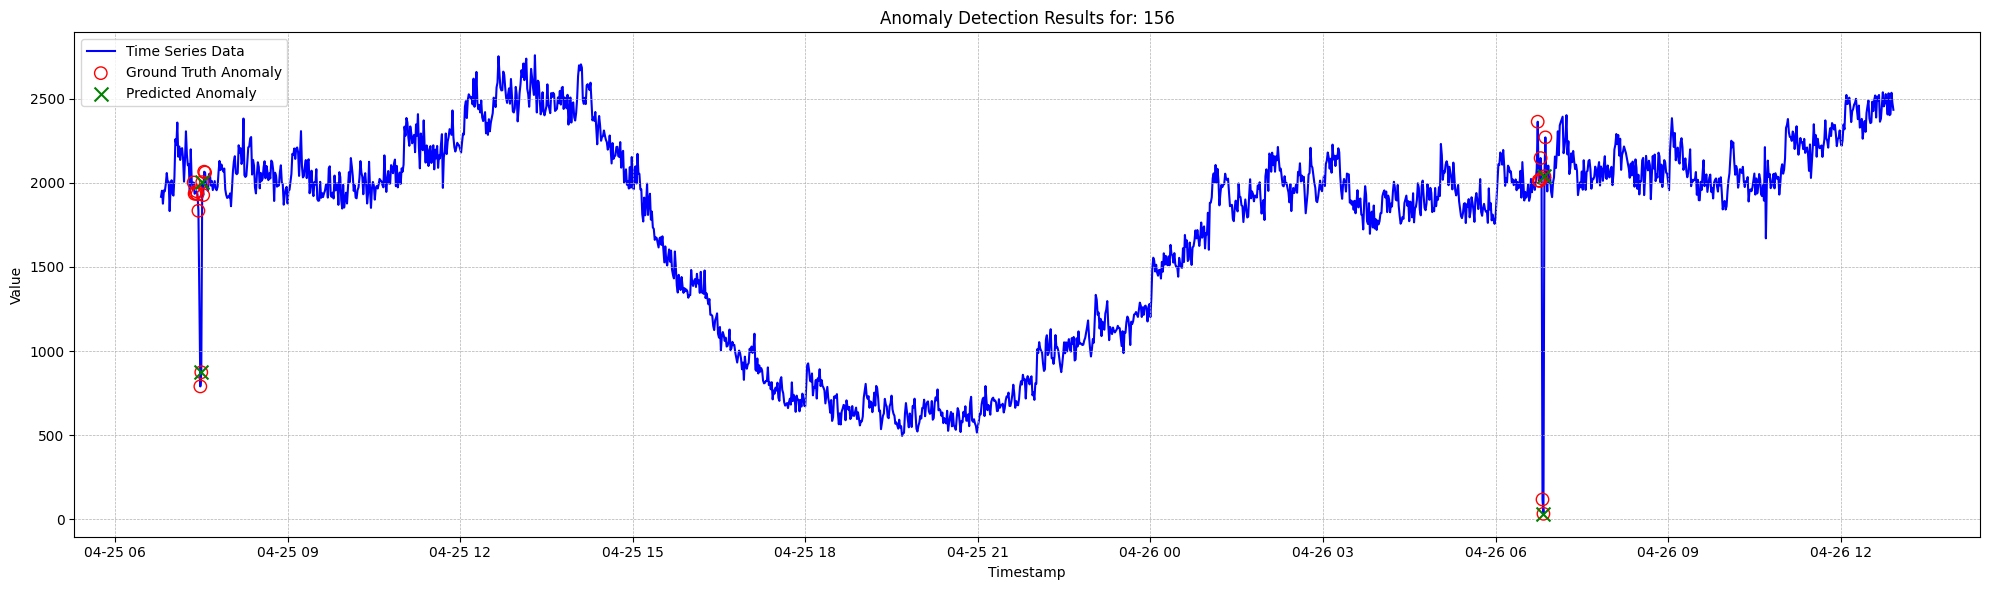

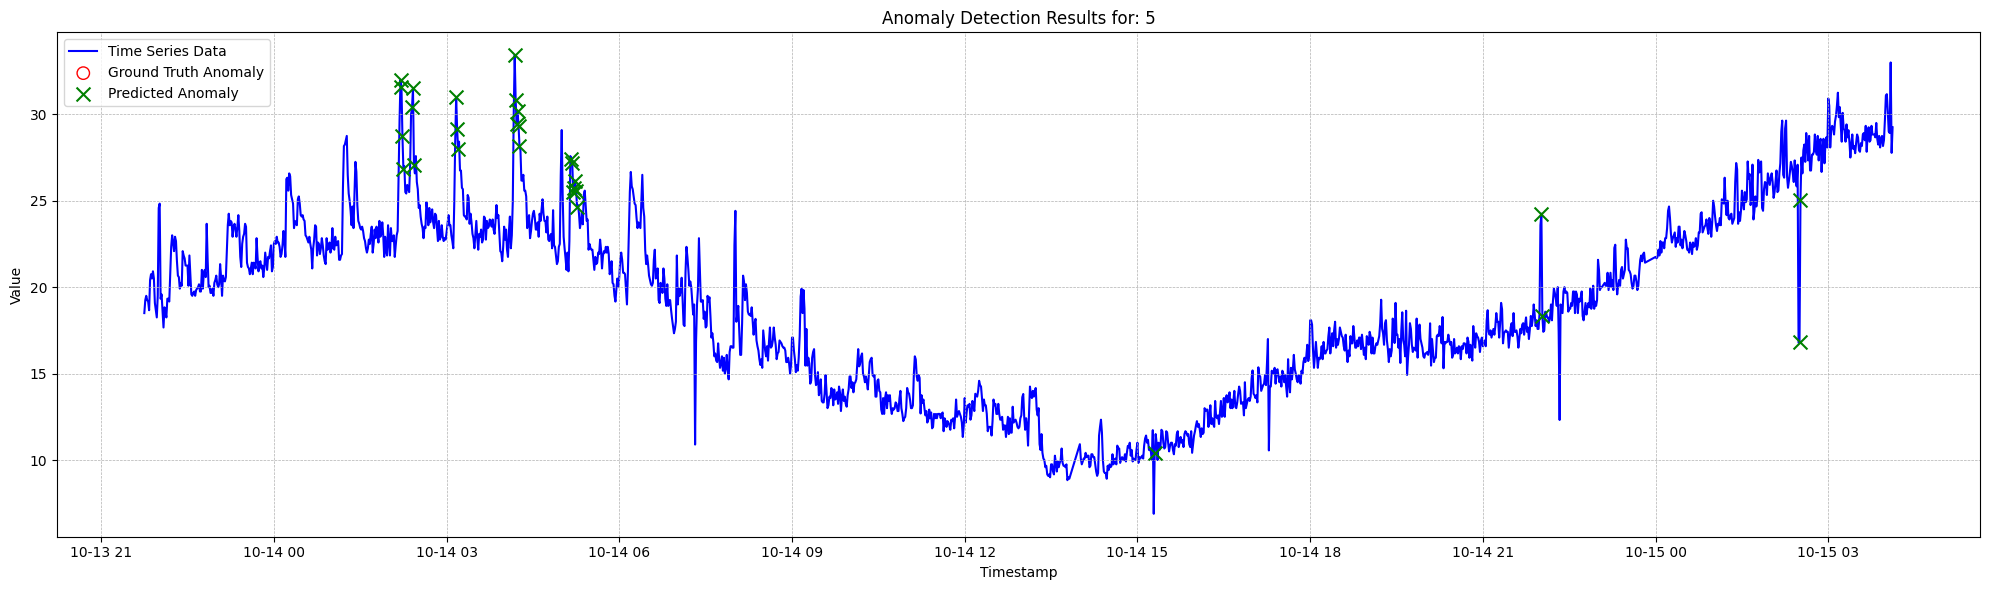

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

print(f"Searching for result files in: {result_path}")
result_files = []
if os.path.isdir(result_path):
    for root, dirs, files in os.walk(result_path):
        if 'predict.csv' in files:
            result_files.append(os.path.join(root, 'predict.csv'))

if not result_files:
    print(f"No 'predict.csv' files found in the subdirectories of '{result_path}'.")
else:
    print(f"Found {len(result_files)} result file(s) to visualize.")

for file_path in result_files:
    try:
        df = pd.read_csv(file_path)
        
        required_cols = ['timestamp', 'raw_value', 'label', 'predict']
        if not all(col in df.columns for col in required_cols):
            print(f"Skipping {file_path}: it does not contain all required columns {required_cols}.")
            continue

        # Convert unix timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        
        ground_truth_anomalies = df[df['label'] == 1]
        predicted_anomalies = df[df['predict'] == 1]
        
        plt.figure(figsize=(20, 6))
        
        # Plot the main time series
        plt.plot(df['timestamp'], df['raw_value'], label='Time Series Data', color='blue', zorder=1)
        
        # Plot ground truth anomalies (hollow red circles)
        plt.scatter(ground_truth_anomalies['timestamp'], ground_truth_anomalies['raw_value'], 
                    label='Ground Truth Anomaly', s=80, zorder=2, facecolors='none', edgecolors='red')
        
        # Plot predicted anomalies (green 'x' markers)
        plt.scatter(predicted_anomalies['timestamp'], predicted_anomalies['raw_value'], 
                    color='green', label='Predicted Anomaly', s=100, zorder=3, marker='x')
        
        plt.title(f'Anomaly Detection Results for: {os.path.basename(os.path.dirname(file_path))}')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not process file {file_path}. Error: {e}")